# LASSO with Patches

In [1]:
import os
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [2]:
TYPES = ['Pedestrian', 'Cyclist', 'Pets']
CARRY_ONS = ['backpack', 'shoulder-bag', 'hand-bag', 'luggage', 'umbrella', 'misc']

In [3]:
def idof(y):
    return y[0]

def typeof(y):
    return TYPES[y[1]]

def is_occluded(y):
    return y[2] == 1

def carry_ons(y):
    c = y[3:]
    return ', '.join([CARRY_ONS[i] for i in range(len(c)) if c[i] == 1])

## Sklearn

In [4]:
from sklearn.decomposition import SparseCoder

### ViaCrops

In [5]:
root = 'PennFudanPed/ViaCropsNOC/'

D = np.load(root + 'train_dict.npy')
y = np.load(root + 'test_dict.npy')
Dl = np.load(root + 'train_labels.npy')
yl = np.load(root + 'test_labels.npy')

D.shape, y.shape, Dl.shape, yl.shape

((200, 128, 64), (334, 128, 64), (200, 9), (334, 9))

In [6]:
from skimage.util import view_as_blocks

s = 16

Dp = []
for i in range(len(D)):
    Dp.append(view_as_blocks(D[i], (s, s)).reshape(-1, s**2))

Dp = np.vstack(Dp)

yp = []
for i in range(len(y)):
    yp.append(view_as_blocks(y[i], (s, s)).reshape(-1, s**2))

yp = np.stack(yp)

Dp.shape, yp.shape

((6400, 256), (334, 32, 256))

(-0.5, 63.5, 127.5, -0.5)

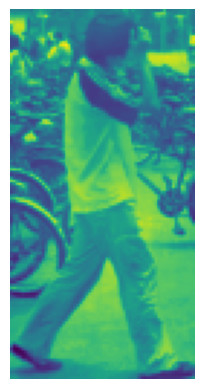

In [13]:
plt.imshow(D[6])
plt.axis('off')

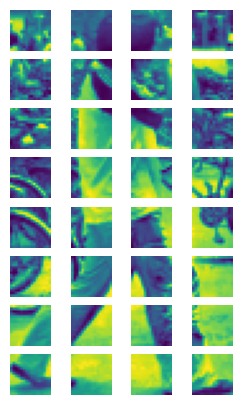

In [18]:
imgs = Dp[6*32:7*32].reshape(-1, 16, 16)
fig, ax = plt.subplots(8, 4, figsize=(3, 5))
for i in range(8):
    for j in range(4):
        ax[i][j].imshow(imgs[4*i+j])
        ax[i][j].axis('off')

In [24]:
dim = s**2
coder = SparseCoder(
     dictionary=Dp, transform_algorithm='lasso_lars',
     transform_alpha=1e0,
)

In [51]:
x = coder.transform(yp[10])
x.shape

(32, 6400)

In [57]:
def sci(x):
    # x -> [n, k]
    k = x.shape[-1]
    l1 = np.linalg.norm(x, ord=1, axis=-1)
    return (k * np.max(np.abs(x), axis=-1) / l1 - 1) / (k - 1)

Text(0, 0.5, 'SCI')

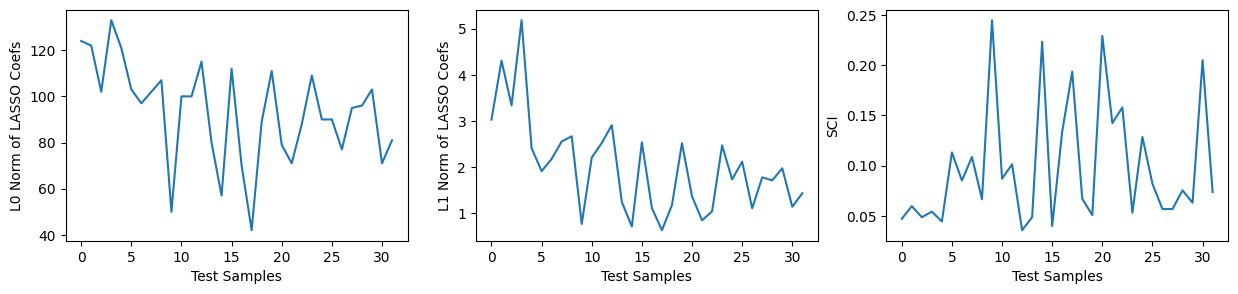

In [58]:
l0 = np.linalg.norm(x, ord=0, axis=1)
l1 = np.linalg.norm(x, ord=1, axis=1)
s = sci(x)

fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(l0)
ax[0].set_xlabel('Test Samples')
ax[0].set_ylabel('L0 Norm of LASSO Coefs')
ax[1].plot(l1)
ax[1].set_xlabel('Test Samples')
ax[1].set_ylabel('L1 Norm of LASSO Coefs')
ax[2].plot(s)
ax[2].set_xlabel('Test Samples')
ax[2].set_ylabel('SCI')

In [112]:
def show_topkp(i, k):
    x = coder.transform(yp[i])
    fig, ax = plt.subplots(1, 3, figsize=(8, 5))
    title = 'Raw {}{} ({})\n{}'.format(
        typeof(yl[i]), idof(yl[i]), 'OCC' if is_occluded(yl[i]) else 'NOC',
        'carry-on: ' + carry_ons(yl[i])
    )
    ax[0].imshow(y[i].reshape(*D.shape[-2:]))
    ax[0].axis('off')
    ax[0].set_title(title)
    img = np.zeros((32, 16, 16))
    pch = np.zeros((32, 16, 16))
    s = sci(x)
    pred = np.zeros((len(x), k))#(yl[i], dtype=float)
    for p in range(len(x)):
        img[p] = np.dot(x[p], Dp).reshape(16, 16)
        ids = np.argsort(x[p])[-k:]
        pred[p] = ids#[0]
        pch[p] = np.dot(x[p, ids], Dp[ids]).reshape(16, 16)# + s[p]
        #pred += np.dot(x[p, ids], Dl[(ids//32).astype(int)]) * s[p]
    # assemble
    img = img.reshape(8, 4, 16, 16)
    img = img.transpose(0, 2, 1, 3).reshape(8, 16, 64)
    img = img.reshape(128, 64)
    ax[1].imshow(img)
    ax[1].axis('off')
    ax[1].set_title('Reconstructed')
    # assemble
    pch = pch.reshape(8, 4, 16, 16)
    pch = pch.transpose(0, 2, 1, 3).reshape(8, 16, 64)
    pch = pch.reshape(128, 64)
    ax[2].imshow(pch)
    ax[2].axis('off')
    ax[2].set_title('Top {} Patches'.format(k))
    return pred

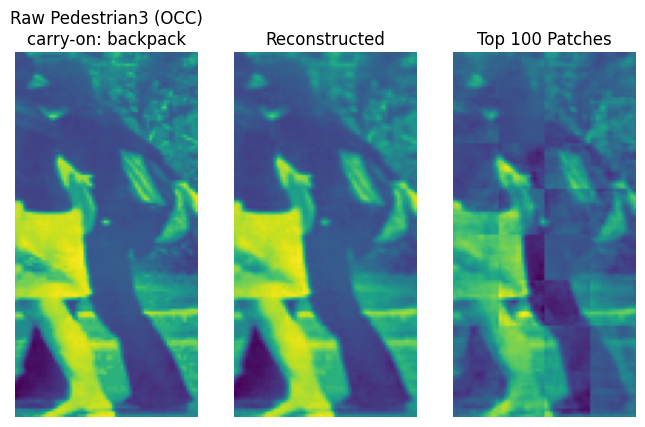

In [113]:
p = show_topkp(1, 100)

In [118]:
np.median(p // 32, axis=1)

array([68. , 68. , 68.5, 68. , 68. , 67. , 67. , 69. , 68. , 68.5, 68. ,
       69. , 67. , 75. , 68.5, 67. , 68. , 67. , 68. , 68.5, 68. , 78. ,
       67. , 67. , 68. , 67. , 68. , 67. , 68. , 68.5, 68. , 67. ])

In [119]:
Dl[[67, 68, 69]]

array([[204,   0,   0,   0,   0,   0,   0,   0,   0],
       [205,   0,   0,   0,   1,   0,   0,   0,   0],
       [207,   0,   0,   0,   0,   0,   0,   0,   0]])

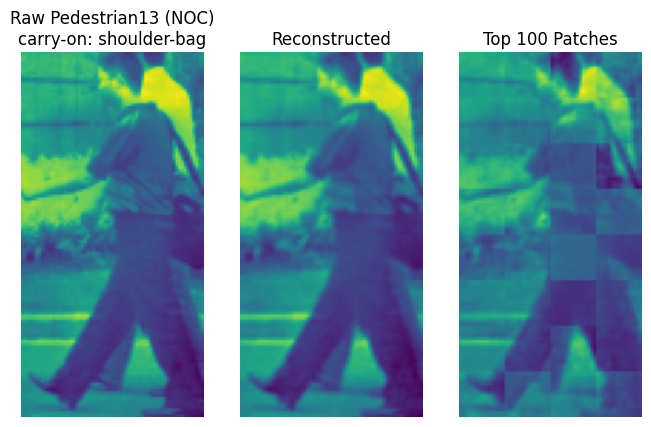

In [120]:
p = show_topkp(9, 100)

In [127]:
np.median(p // 32, axis=1)

array([67. , 69. , 69.5, 68. , 67. , 67. , 69. , 68.5, 68. , 68. , 68. ,
       67.5, 67.5, 87.5, 68. , 68. , 68. , 68. , 68. , 67. , 67. , 68. ,
       67. , 68. , 68. , 67. , 67. , 67.5, 68. , 68. , 69. , 67.5])

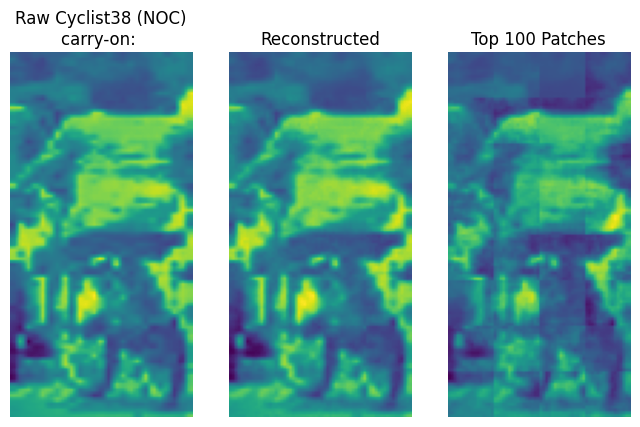

In [128]:
p = show_topkp(30, 100)

In [129]:
np.median(p // 32, axis=1)

array([68. , 68. , 67. , 67. , 68. , 69. , 67. , 68. , 67. , 67. , 68. ,
       69. , 69. , 68. , 67. , 67. , 68. , 68. , 67. , 67. , 67. , 67. ,
       68. , 68. , 68. , 69. , 69. , 69. , 69.5, 69. , 69. , 67.5])